In [1]:
using Agents
using Random
using DataFrames
using Distributions
using DrWatson
using StatsPlots

In [2]:
function rate_to_proportion(r::Float64, t::Float64)
    1 - exp(-r*t)
end

# create Person structure as a subtype of AbstractAgent
mutable struct Person <: AbstractAgent
    id::Int64
    status::Symbol
end

# function to set up the model, by setting parameter fields and adding agents to the model
function init_model(β::Float64, c::Float64, γ::Float64, N::Int64, I0::Int64)
    properties = @dict(β, c, γ)
    model = ABM(Person; properties=properties)
    # set I0 agents to be infected, and the rest (up to N) as susceptible
    for i in 1:N
        if i <= I0
            s = :I # these are symbols, as defined in the Person struct
        else
            s = :S
        end
        # instatiate a "Person" agent with appropriate id and status, and add to model
        p = Person(i, s)
        p = add_agent!(p, model)
    end
    return model
end


function transmit!(agent, model, N)
    agent.status != :S && return # short-circuit "and" evaluation here means that if status is not :S, function returns here, ie this agent cannot be infected 

    ncontacts = rand(Poisson(model.properties[:c])) # how many contacts has our agent made in time δt?

    all_agent_ids = 1:N
    agent_ids = all_agent_ids[all_agent_ids .!= agent.id] # agent ids excluding our agent itself

    for i in 1:ncontacts
        
        alter = model[rand(agent_ids)]

        if alter.status == :I && (rand() ≤ model.properties[:β])
            # An infection occurs
            agent.status = :I
            break
        end
    end
end

function recover!(agent, model)
    agent.status != :I && return
    if rand() ≤ model.properties[:γ]
            agent.status = :R
    end
end

function agent_step!(agent, model)
    transmit!(agent, model, N)
    recover!(agent, model)
end

susceptible(x) = count(i == :S for i in x)
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

recovered (generic function with 1 method)

In [3]:
δt = 0.1
nsteps = 400
tf = nsteps * δt
t = 0:δt:tf

# β = 0.05 # prob of a contact causing infection
# c = 10.0 * δt # poissonian expectation value of number of contacts in time step
γ = rate_to_proportion(0.25, δt) # prob of recovery for each time step (if infected)

β = 0.4 # prob of a contact causing infection
c = 0.3 # poissonian expectation value of number of contacts in time step

N = 1000 # total agents
I0 = 10 # initial infected

Random.seed!(1234)

abm_model = init_model(β, c, γ, N, I0)

to_collect = [(:status, f) for f in (susceptible, infected, recovered)]

3-element Vector{Tuple{Symbol, Function}}:
 (:status, susceptible)
 (:status, infected)
 (:status, recovered)

In [4]:
abm_data, _ = run!(abm_model, agent_step!, nsteps; adata = to_collect)
abm_data[!, :t] = t

0.0:0.1:40.0

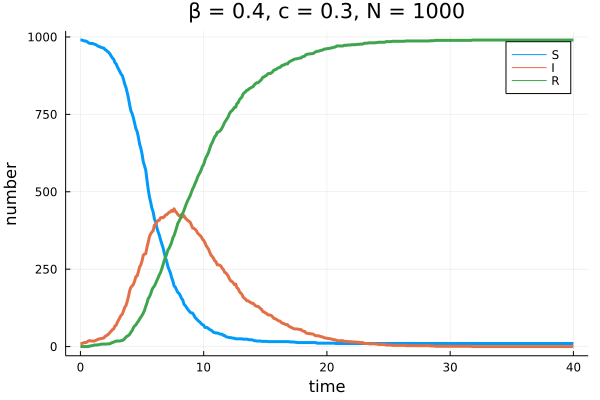

In [5]:
title = "β = " * string(β) * ", c = " * string(c) * ", N = " * string(N) 
plot(t, abm_data[:, 2], label="S", xlab="time", ylabel="number", title = title, lw=3)
plot!(t,abm_data[:, 3], label="I", lw = 3)
plot!(t,abm_data[:, 4], label="R", lw = 3)